# Train Log 20181206

* Add multi-model training structure

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

# sys.path.append( os.path.abspath('../../../Dataset/scripts'))
# from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *

import multiprocessing

import tensorflow as tf


In [3]:
""" Path """
data_train_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/train.h5')
data_vali_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/vali.h5')


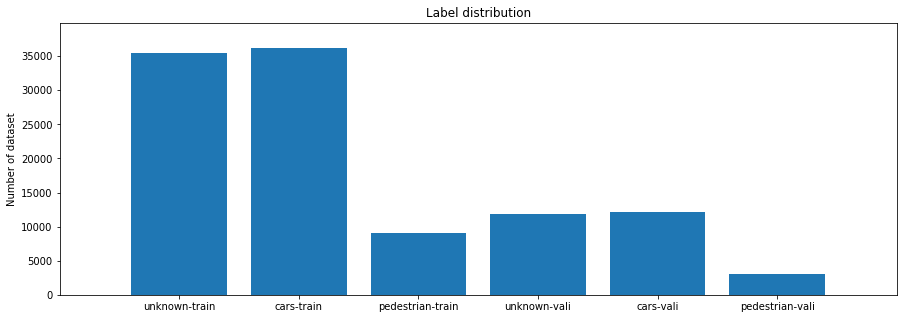

In [4]:
""" Load dataset"""

data = []
class_label = []
heading_label = []

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    class_label = f['class'][:]
    heading_label = f['heading'][:]
    return (data, class_label, heading_label)

data_train, class_label_train, heading_label_train = load_h5(data_train_path)
data_vali, class_label_vali, heading_label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
class_label.append(class_label_train)
class_label.append(class_label_vali)
heading_label.append(heading_label_train)
heading_label.append(heading_label_vali)

""" Data statistics """

label_list = [0,1,2]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(class_label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train','pedestrian-train',
        'unknown-vali', 'cars-vali', 'pedestrian-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [6]:
import os, sys

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

"""
Import model 
"""
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading_3 as MODEL



def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 2
    
    HEADING_LOSS_WEIGHT = 0.1


    
    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    
    """
    load traing model
    """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=HEADING_LOSS_WEIGHT)
            tf.summary.scalar('loss', loss)
            
            classify_loss = MODEL.get_classify_loss(pred, class_labels_pl)
            mat_diff_loss = MODEL.get_mat_diff_loss(end_points)
            heading_loss = MODEL.get_heading_loss(pred, heading_labels_pl)
            
            tf.summary.scalar('classify_loss', classify_loss)
            tf.summary.scalar('mat_diff_loss', mat_diff_loss)
            tf.summary.scalar('heading_loss', heading_loss)

            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'classify_loss': classify_loss,
               'mat_diff_loss': mat_diff_loss,
               'heading_loss': heading_loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            print "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH)
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            class_results = []
            heading_results = []
            

            """
            Run batch training
            """
            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val,loss_cls,loss_mat,loss_hea, pred_val = sess.run([ops['merged'], 
                                                                 ops['step'],
                                                                 ops['train_op'], 
                                                                 ops['loss'], 
                                                                 ops['classify_loss'],
                                                                 ops['mat_diff_loss'],
                                                                 ops['heading_loss'],
                                                                 ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)
                
                """
                Evaluation
                """
                # heading
                heading_results.extend(pred_val[:,3])
                # class
                pred_val_class = np.argmax(pred_val[:,:3], 1)
                class_results.extend(pred_val_class)
            
            """
            Results
            """
            ## Loss
            print "Total loss: {}".format(np.mean(loss_val))
            print "- cls loss: {}".format(np.mean(loss_cls))
            print "- mat loss: {}".format(np.mean(loss_mat))
            print "- heading loss: {}".format(np.mean(loss_hea))
            
            
            
            ## Classification
            prediction = np.array(class_results)
            ground_truth = np.array(current_class_label[:num_batches*BATCH_SIZE])
            cm = confusion_matrix(ground_truth, prediction)
            label_list = ['unknown', 'car', 'pedes']
            print(classification_report(ground_truth, prediction, target_names=label_list))
            
            ## Heading
            y_pred = np.asarray(heading_results)
            y_true = np.asarray(current_heading_label[:num_batches*BATCH_SIZE])
            y_pred = y_pred.reshape(y_true.shape)

            error = np.abs(y_true - y_pred)
            rmse = np.square( np.mean (error**2) )
        #     print('- Explained_variance_score: {}'.format(explained_variance_score(y_true, y_pred)))
        #     print('- R2_score: {}'.format(r2_score(y_true, y_pred)))
            print('- Root mean_squared_errors [deg]: {}'.format(rmse * 360.))
                
            
            """
            Evaluation using validation set    
            """
            
            print " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH)
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            class_results = []
            heading_results = []
                       
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, loss_cls, loss_mat, loss_hea, pred_val = sess.run([ops['merged'], ops['step'],
                                                              ops['loss'], 
                                                              ops['classify_loss'], 
                                                              ops['mat_diff_loss'], 
                                                              ops['heading_loss'], 
                                                              ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                """
                Evaluation
                """
                # heading
                heading_results.extend(pred_val[:,3])

                pred_val_class = np.argmax(pred_val[:,:3], 1)
                class_results.extend(pred_val_class)
            
            ## Loss
            print "Total loss: {}".format(np.mean(loss_val))
            print "- cls loss: {}".format(np.mean(loss_cls))
            print "- mat loss: {}".format(np.mean(loss_mat))
            print "- heading loss: {}".format(np.mean(loss_hea))
            
            
            ## Classification
            prediction = np.array(class_results)
            ground_truth = np.array(current_class_label[:num_batches*BATCH_SIZE])
            cm = confusion_matrix(ground_truth, prediction)
            label_list = ['unknown', 'car', 'pedes']
            print(classification_report(ground_truth, prediction, target_names=label_list))
            
            ## Heading
            y_pred = np.asarray(heading_results)
            y_true = np.asarray(current_heading_label[:num_batches*BATCH_SIZE])
            y_pred = y_pred.reshape(y_true.shape)

            error = np.abs(y_true - y_pred)
            rmse = np.square( np.mean (error**2) )
        #     print('- Explained_variance_score: {}'.format(explained_variance_score(y_true, y_pred)))
        #     print('- R2_score: {}'.format(r2_score(y_true, y_pred)))
            print('- Root mean_squared_errors [deg]: {}'.format(rmse * 360.))
            
                
            """
            Save the variables to disk.
            """
#             if ( epoch + 1 ) % 10 == 0:
            save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
            print "Model saved in file: %s" % save_path

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_4',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)


 Train one epoch   1 /   2


100%|██████████| 1615/1615 [09:45<00:00,  2.76it/s]


Total loss: 0.430615007877
- cls loss: 0.419095903635
- mat loss: 2.12083029747
- heading loss: 0.0939829200506
             precision    recall  f1-score   support

    unknown       0.73      0.66      0.70     35515
        car       0.73      0.79      0.76     36235
      pedes       0.83      0.87      0.85      9000

avg / total       0.74      0.74      0.74     80750

- Root mean_squared_errors [deg]: 11.5010654926
 Evaluation one (validation set) epoch   1 /   2


100%|██████████| 538/538 [00:45<00:00, 11.74it/s]


Total loss: 0.391478121281
- cls loss: 0.381946831942
- mat loss: 2.26346325874
- heading loss: 0.0726783648133
             precision    recall  f1-score   support

    unknown       0.75      0.91      0.82     11805
        car       0.97      0.73      0.83     12102
      pedes       0.77      0.92      0.84      2993

avg / total       0.85      0.83      0.83     26900

- Root mean_squared_errors [deg]: 2.64644645154


 Train one epoch   2 /   2


100%|██████████| 1615/1615 [09:44<00:00,  2.76it/s]


Total loss: 0.534535527229
- cls loss: 0.521973490715
- mat loss: 2.83400273323
- heading loss: 0.097280010581
             precision    recall  f1-score   support

    unknown       0.85      0.82      0.83     35517
        car       0.86      0.87      0.87     36233
      pedes       0.87      0.92      0.89      9000

avg / total       0.85      0.85      0.85     80750

- Root mean_squared_errors [deg]: 2.66691606492
 Evaluation one (validation set) epoch   2 /   2


100%|██████████| 538/538 [00:45<00:00, 11.72it/s]


Total loss: 0.414387494326
- cls loss: 0.4032368958
- mat loss: 3.01515316963
- heading loss: 0.0813543200493
             precision    recall  f1-score   support

    unknown       0.89      0.96      0.92     11803
        car       0.99      0.90      0.94     12101
      pedes       0.89      0.91      0.90      2996

avg / total       0.93      0.93      0.93     26900

- Root mean_squared_errors [deg]: 2.53443807364
